## Imports

In [1]:
import io
import requests

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.units import Quantity
import numpy as np
from astropy.utils.data import download_file
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import wcs
import astropy.io.fits as fits
from astropy.io.fits import getdata, getheader

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from rama import read_url, is_template, count, unroll
from rama.models.source import Source, SourcePosition, LuminosityMeasurement, Detection
from rama.models.coordinates import SpaceFrame
from rama.models.photdmalt import PhotometryFilter

# Suppress votable parse warnings.
import warnings
warnings.filterwarnings("ignore")

## Data Retrieval

## HSC Matches Query

In [2]:
def cone_search(base_url, coord: SkyCoord, radius):
    # Make sure the coordinates are expressed in ICRS and degress
    ra = coord.icrs.ra.deg
    dec = coord.icrs.dec.deg
    # Make sure radius is in degrees
    radius_deg = radius.to(u.deg).value
    
    # Cone search params.
    params = {'RA': ra, 'DEC': dec, 'SR': radius_deg}

    return read_url(base_url, params)

# Define Cone Search parameters
search_coord = SkyCoord.from_name("m82")
search_radius = 0.001 * u.deg

# HSC Cone Base URL (could we get it from the registry?)
HSC_MATCHES_URL = 'https://masttest.stsci.edu/vodml/Mashup/VoQuery.asmx/HscCone?'

# Make search and parse results into Source objects
hsc_matches_results = cone_search(HSC_MATCHES_URL, search_coord, search_radius)
source_template = hsc_matches_results.find_instances(Source)[0]

# By default tabular instances are described as "templates" that provide
# access to individual columns. We can unroll the templates so to
# get one Source instance per row. We'll use templates for the cutouts at the end
# of the notebook.
assert is_template(source_template)
sources = unroll(source_template)

# Get Astropy table representing the results
# kind of a hack, we need to improve the API
matches_table = list(hsc_matches_results.tables.values())[0]

# Show info
print(f'{source_template.cardinality} matches found.')
matches_table.show_in_notebook()

19 matches found.


idx,MatchID,Distance,MatchRA,MatchDec,DSigma,AbsCorr,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,TargetName,CI,CI_Sigma,KronRadius,KronRadius_Sigma,Extinction,SpectrumFlag,W2_F336W,W2_F336W_Sigma,W2_F336W_N,W2_F439W,W2_F439W_Sigma,W2_F439W_N,W2_F502N,W2_F502N_Sigma,W2_F502N_N,W2_F547M,W2_F547M_Sigma,W2_F547M_N,W2_F555W,W2_F555W_Sigma,W2_F555W_N,W2_F631N,W2_F631N_Sigma,W2_F631N_N,W2_F656N,W2_F656N_Sigma,W2_F656N_N,W2_F658N,W2_F658N_Sigma,W2_F658N_N,W2_F814W,W2_F814W_Sigma,W2_F814W_N,_selected_
,none,arcminutes,deg,deg,mas,,,,,days,days,,ABmag,ABmag,arcs,arcs,ABmag,,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,ABmag,
0,17350615.0,0.00883306720656974,148.96888203758,69.6797072526489,0.0,Y,1,1,1,54834.6258381181,54834.6575510763,NGC3034,3.03022225697835,0.0,0.349999994039536,0.0,0.153628796339035,N,21.7112998962402,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,--
1,17112744.0,0.0131180875647911,148.968997760412,69.6795900802937,24.9352755222915,Y,5,2,7,50523.2968749586,51053.1723864423,NGC3034-OUTFLOW,4.40160139654805,0.201972231036192,0.455,5.99588961666477e-17,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,19.6096000671387,0.0,1.0,19.1471004486084,0.0,1.0,nan,nan,0.0,18.4589004516602,0.0,1.0,16.551344871521,0.141215544746661,2.0,17.1591949462891,0.258807275140784,2.0,nan,nan,0.0,--
2,17115228.0,0.020600919203083,148.968682222876,69.6800372272498,0.0,N,2,1,2,50706.0557152592,50706.5385857429,NGC3034B-2,1.46466158982634,0.280854668066096,0.349999994039536,0.0,0.153628796339035,N,nan,nan,0.0,23.6833992004395,0.0,1.0,nan,nan,0.0,nan,nan,0.0,21.4559001922607,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,--
3,17111544.0,0.0303987662778864,148.967404818518,69.6793523018495,0.0,Y,1,1,1,51053.0043308656,51053.0177567475,NGC3034-OUTFLOW,0.893353515521277,0.0,0.455,0.0,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,19.2964992523193,0.0,1.0,nan,nan,0.0,nan,nan,0.0,--
4,17109683.0,0.0319055670213261,148.968358648006,69.6802334322381,0.0,N,3,1,3,50706.0557152592,50706.5385857429,NGC3034B-2,2.09449786486391,0.388645102107531,0.349999994039536,0.0,0.153628796339035,N,nan,nan,0.0,22.9946994781494,0.0,1.0,nan,nan,0.0,nan,nan,0.0,20.3750991821289,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,18.8915004730225,0.0,1.0,--
5,17114183.0,0.032588602427965,148.96711764508,69.6794230683398,0.0,Y,2,1,2,51053.0043308656,51053.0362752476,NGC3034-OUTFLOW,1.90672206374454,0.115679347320594,0.455,0.0,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,18.8257007598877,0.0,1.0,19.4087009429932,0.0,1.0,nan,nan,0.0,--
6,17113460.0,0.0345891900125784,148.967783047583,69.6802294411111,0.0,N,2,1,2,50706.0557152592,50706.411270882,NGC3034B-2,1.49194795240549,0.305330827860097,0.349999994039536,0.0,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,20.3157997131348,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,18.3355007171631,0.0,1.0,--
7,17114343.0,0.0348678278920604,148.96909172414,69.6791649101117,0.0,Y,1,1,1,54834.6258381181,54834.6575510763,NGC3034,2.26777765485975,0.0,0.349999994039536,0.0,0.153628796339035,N,20.3945007324219,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,--
8,17111787.0,0.0363046062064173,148.968825628571,69.6802942781797,124.635228628899,Y,5,2,5,50706.0557152592,51053.1723864423,NGC3034B-2,2.43431607887766,0.195207045634591,0.433999998807907,0.0469574301930963,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,20.5723991394043,0.0,1.0,21.6469993591309,0.0,1.0,19.9225006103516,0.0,1.0,16.6112003326416,0.0,1.0,17.3407001495361,0.0,1.0,nan,nan,0.0,--


In [3]:
def is_valid_luminosity(luminosity: LuminosityMeasurement):
    '''
    A boolean function that returns whether a luminosity value is valid
    '''
    value = luminosity.value
    return value is not None and ~np.isnan(value)

def get_luminosities(source: Source):
    '''
    A function that returns all lumino
    '''
    return [lumin for lumin in source.luminosity
            if is_valid_luminosity(lumin)]

In [4]:
def print_source_properties(source, index):
    print(f"{int(source.name.value)}, "
          f"{matches_table[index]['NumImages']},",
          len(get_luminosities(source)))
    
print("Name, #Images, #Luminosities")
for idx, source in enumerate(sources):
    print_source_properties(source, idx)

Name, #Images, #Luminosities
17350615, 1, 1
17112744, 7, 5
17115228, 2, 2
17111544, 1, 1
17109683, 3, 3
17114183, 2, 2
17113460, 2, 2
17114343, 1, 1
17111787, 5, 5
17113463, 4, 4
17113661, 1, 1
17350576, 1, 1
17111042, 1, 1
17115009, 1, 1
17115007, 2, 2
17111068, 3, 3
17115017, 6, 4
17110937, 1, 1
17115272, 1, 1


### Find a bright-ish source with multiple luminosties.

In [5]:
filters = hsc_matches_results.find_instances(PhotometryFilter)
b_filters = PhotometryFilter.find(lambda phot_filter: phot_filter.band_name == "B", filters)

def is_source_bright_in_band(source: Source, phot_filters, cut_off):
    for luminosity in source.luminosity:
        filter_in_selection = luminosity.filter in phot_filters
        if filter_in_selection and luminosity.value.value < 23:
            return True
    return False

def is_bright_source_with_multiple_luminosities(phot_filters, cut_off):
    def source_filter(source: Source):
        is_bright = is_source_bright_in_band(source, phot_filters, cut_off)
        has_enough_luminosities = len(get_luminosities(source)) > 1
        return is_bright and has_enough_luminosities
    return source_filter

matching_sources = Source.find(is_bright_source_with_multiple_luminosities(b_filters, 23),
                              sources)

In [6]:
def luminosity_in_band(source, phot_filters):
    for luminosity in source.luminosity:
        filter_in_selection = luminosity.filter in phot_filters
        if filter_in_selection:
            return luminosity.value

def find_brightest(sources, phot_filters):
    brightest = None
    brightest_luminosity = None
    for source in sources:
        if brightest is None:
            brightest = source
            brightest_luminosity = luminosity_in_band(source, phot_filters).value
            continue
        for luminosity in source.luminosity:
            if luminosity_in_band(source, phot_filters) < brightest_luminosity:
                brightest = source
    return brightest

brightest = find_brightest(matching_sources, b_filters)
print(int(brightest.name.value))

17109683


### Load detections for "bright" multi-image source

In [7]:
HSC_DETECTIONS_BASE_URL = 'https://masttest.stsci.edu/vodml/Mashup/VoQuery.asmx/HscDetections?'
params = {'MATCHID': brightest.name.value}
detection_results = read_url(HSC_DETECTIONS_BASE_URL, params)

detection_template = detection_results.find_instances(Detection)[0]
print(f"{detection_template.cardinality} detections found")

3 detections found


### Plot cutouts of the detection from each image.

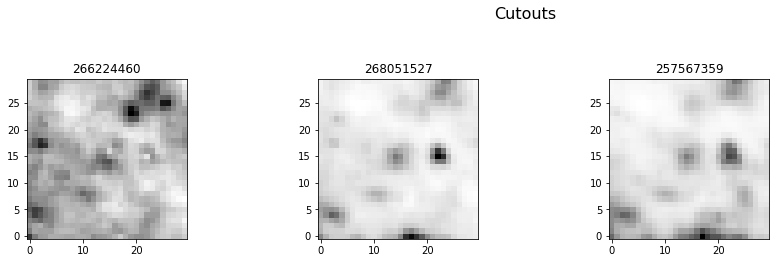

In [8]:
#Set up the figure.
fig = plt.figure(figsize=(20,10))
plt.suptitle('Cutouts', fontsize=16)

for idx in range(detection_template.cardinality):
    #Make the title be the name of the detection.
    title = detection_template.name[idx]
    ra = detection_template.position[0].coord[idx].icrs.ra.deg
    dec = detection_template.position[0].coord[idx].icrs.dec.deg
    filename = detection_template.source_image[0].url[idx]
    
    # Plot the first image data we find.
    hdu_list = fits.open(filename)
    for hdu_idx in range(len(hdu_list)):
        h = hdu_list[hdu_idx].header
        prime_or_image = (hdu_idx == 0) or (h.get('XTENSION') == 'IMAGE')
        is_image = (h.get('NAXIS') == 2) and prime_or_image
        if (is_image):
            break
    
    #Read in the image, header, and WCS
    data = getdata(filename, hdu_idx)
    header = getheader(filename, hdu_idx)
    w = wcs.WCS(header)

    #Make a cutout centered on the detection.
    position = SkyCoord(ra, dec, unit = 'deg')
    size = 30.0 #* u.arcsec
    cutout = Cutout2D(data, position, (size, size), wcs=w)

    #Make a subplot for this image.
    ax = fig.add_subplot(3,4,idx+1)
    ax.imshow(cutout.data, cmap='gray_r', origin='lower')
    ax.set_title(title)

